# Does basic house information reflect house's description?

## Data download

First of all we should download all the data. We do it by scarping the website reading all the features from the announcement, aswell as the link to the page contaning it. We visit this page and download the complete description aswell.

If any element is missing, we place a $0$ or a 'NaN' value, depending if it is a numeric or a string value. In this way we will consider similar, in the clustering, elements not having those values.

In [ ]:
import data_downloader
descriptions_list,list_features_all_c = data_downloader.downloader()

We save everything in a file, in this way we can do the further computation without having to repeat each time this step.

In [2]:
import pickle
with open('raw_data.pkl', 'wb') as f:
    pickle.dump((descriptions_list,list_features_all_c), f, pickle.HIGHEST_PROTOCOL)    

## Data preprocessing

First of all let us load our data.

In [ ]:
import pickle
with open('raw_data.pkl', 'rb') as f:
    loaded = pickle.load(f)
    list_features = loaded[1]
    list_description = loaded[0]

Now, given our two elements from the scraping, we have to process them in a form which can be used for the clustering process. 

The matrix of features has only to be transformed in an array of numpy, and we do it directly.

For the matrix of the description we process it more accurately. We remove punctation and reduce everything to small cases. We also proceed to the stemming of those words by the snowball stemmer from the nltk library for the italian language. Finally, we compute the tfIdf value of each couple document-word an build a matrix out of it. We place a $0$ where the word is missing.

In [2]:
import tfIdf_functions
import numpy as np
df = tfIdf_functions.tfIdf_calculator(tfIdf_functions.cleaner(list_description))
description_matrix = np.nan_to_num(df.values)
features_matrix = np.array(list_features)

We save everything in a file, in this way we can do the further computation without having to repeat each time this step.

In [3]:
import pickle
with open('processed_data.pkl', 'wb') as f:
    pickle.dump((description_matrix,features_matrix), f, pickle.HIGHEST_PROTOCOL)

## Clustering

### Clustering preliminaries

#### Principal component analysis

Before we start to build the actual cluster we need to prepare the data. The most important thing is to check how many cluster we should use in our clustering, and to do so we wish to use the elbow method.

First of all let us load our data.

In [1]:
import pickle
with open('processed_data.pkl', 'rb') as f:
    loaded = pickle.load(f)
    features_matrix = loaded[1]
    description_matrix = loaded[0]

In [5]:
print(len(description_matrix[0]))

43110


Unluckly the description matrix has a very huge number of features, therefore the computation will be very slow, in the order of days of computation, to find an optimal cluster.

For solve this problem we will apply a method of dimension reduction to our data to get a more usable amount of data. In particular, we will use the principal component reduction method. It is a widly used method in statistic to reduce the dimension of random variable without losing too much information. In particular we will set a treshold value of $0.95$ for the variance ratio of our data. That is, we will check how much is the variance rate given by our PCA reduction for different dimensions and choose the first we found having a variance ratio of $0.95$. That means that we are losing $5$% of our initial information.

In [6]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

for n in range(2000,len(description_matrix[0]),2000):
    pca = PCA(n_components=n).fit(description_matrix)
    value = np.cumsum(pca.explained_variance_ratio_)
    print(n, value[-1])
    if value[-1] > 0.95:
        break

2000 0.7840067011271737
4000 0.9017899096133876
6000 0.9592280990090822


We printed in the first column the number of dimension, and in the second the variance, indicating the precision of the PCA.

As we can see we reduced the dimension of our space from $43110$ to only $6000$ losing around $5$% of precision. We now overwrite our matrx with the reducted one.

In [2]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=6000)
description_matrix = pca.fit_transform(description_matrix)

As usual, we will now save our new data for future uses.

In [3]:
import pickle
with open('pca_data.pkl', 'wb') as f:
    pickle.dump((description_matrix,features_matrix), f, pickle.HIGHEST_PROTOCOL)

#### Elbow method

As another step to be able to build our clusters we need to decide the size of them. To do so we apply the Elbow method.

First of all let us load our data.

In [2]:
import pickle
with open('pca_data.pkl', 'rb') as f:
    loaded = pickle.load(f)
    features_matrix = loaded[1]
    description_matrix = loaded[0]

Now we applay the method to the descripton matrix. We devide the process in smaller step do to computational time issues.

In [5]:
import clustering_functions

clustering_functions.elbow_values([250,500],description_matrix)

N_Cluster=250 SSD=57664008.48937336
N_Cluster=500 SSD=55246313.408106714


In [3]:
import clustering_functions

clustering_functions.elbow_values([750,1000],description_matrix)

N_Cluster=750 SSD=52830867.484514326
N_Cluster=1000 SSD=50408147.90713236


In [4]:
import clustering_functions

clustering_functions.elbow_values([1500],description_matrix)

N_Cluster=1500 SSD=45637160.245910875


Let us now plot our data, to have a better idea of what is going on. TODO: compilare e runnare la prossima cella

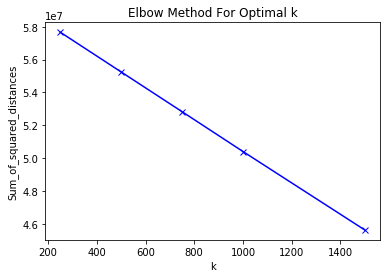

In [12]:
import matplotlib.pyplot as plt

plt.plot([250,500,750,1000,1500], [57664008.48937336,55246313.408106714,52830867.484514326,50408147.90713236,45637160.245910875], 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

As we can see from the data we notice that elbow method does not give any very useful answer. In the first $1500$ clusters we do not see an appreciable reduction in the pendence of the curve, meaning that we don't have an appreciable reduction of the SSD. We do not think that clustering $10000$ with thousands of cluster, obtaning a couple of announcement per cluster, will be useful. Knowing that the final aim is to discover if clustering with the features or clustering with the words lead to the same result, we will use the same number of cluster we are going to find for the other matrix for this one aswell. If the two set of values lead to the same cluster, choosing the same value is naturall. Otherwise we will just find a "contraddiction".

Now we do the same for the features_matrix.

In [33]:
import clustering_functions

SSD_features = clustering_functions.elbow_values(range(1,15),features_matrix,True)

C:\Users\facch\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


N_Cluster=1 SSD=50075.000000000815
N_Cluster=2 SSD=30796.71143726061
N_Cluster=3 SSD=25968.974128411162
N_Cluster=4 SSD=22264.665379332127
N_Cluster=5 SSD=19293.706629831588
N_Cluster=6 SSD=16700.245737957073
N_Cluster=7 SSD=14770.741958505001
N_Cluster=8 SSD=13401.223135597596
N_Cluster=9 SSD=12462.762838817422
N_Cluster=10 SSD=11539.668451324322
N_Cluster=11 SSD=10740.438414964348
N_Cluster=12 SSD=10093.81479385999
N_Cluster=13 SSD=9484.242730597274
N_Cluster=14 SSD=8941.865815879557


Let us now plot our data, to have a better idea of what is going on.

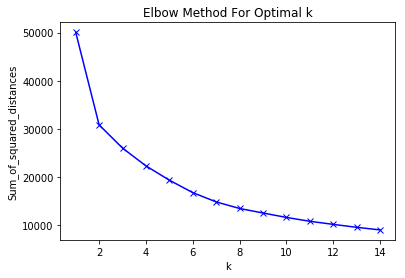

In [35]:
import matplotlib.pyplot as plt

plt.plot(range(1,15), SSD_features, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

As we can see from both the data and the graph the optimal number of cluster for our features_matrix is seven.

### Cluster creation

Now we can compute the clusters.

First of all let us load our data.

In [5]:
import pickle
with open('pca_data.pkl', 'rb') as f:
    loaded = pickle.load(f)
    features_matrix = loaded[1]
    description_matrix = loaded[0]

Now we just need to compute the cluster, with the optimal number of clusters found in the previous analysis.

In [6]:
import clustering_functions

features_cluster_list, descriptions_cluster_list = clustering_functions.find_clusters(7,features_matrix,7,description_matrix)

We save as usual the two cluster list for future use.

In [7]:
import pickle
with open('clusters.pkl', 'wb') as f:
    pickle.dump((descriptions_cluster_list,features_cluster_list), f, pickle.HIGHEST_PROTOCOL)

### Cluster comparision

We import the cluster lists created in the precedent section.

In [1]:
import pickle
with open('clusters.pkl', 'rb') as f:
    loaded = pickle.load(f)
    features_cluster_list = loaded[1]
    descriptions_cluster_list = loaded[0]

And the raw data.

In [2]:
import pickle
with open('raw_data.pkl', 'rb') as f:
    loaded = pickle.load(f)
    list_features = loaded[1]
    list_description = loaded[0]

We compute the Jaccard index of each couple of cluaster, a value that give us a measure of how much two set are similar.

In [3]:
import clustering_functions

results_list = clustering_functions.jaccard_sim_matrix(features_cluster_list,descriptions_cluster_list)

We print our results as a double entry matrix having as index of rows the feature's cluster and of columns the description's cluster labels. 

In [4]:
import pandas as pd

Jaccard_sim = pd.DataFrame(results_list)
Jaccard_sim

,0,1,2,3,4,5,6
0,0.008277,0.089184,0.475476,0.003606,0.016117,0.001328,0.000380
1,0.003960,0.001894,0.045009,0.000000,0.000000,0.000000,0.000000
2,0.009524,0.000000,0.001211,0.000000,0.000000,0.000000,0.000000
3,0.008835,0.018028,0.121020,0.000000,0.009962,0.000000,0.000000
4,0.000000,0.000000,0.000110,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.011339,0.000000,0.003861,0.000000,0.000000
6,0.011557,0.035524,0.303834,0.000975,0.017738,0.001632,0.000327


We get the three biggest Jaccard index presented in a dataframe.

In [5]:
import comparison_functions

top3df = comparison_functions.top3extractor(Jaccard_sim)
top3df

,feature index,description index,Jaccard index
0,0,2,0.475476
1,3,2,0.121020
2,6,2,0.303834


As we can see we have a cluster that's almos half the same as the other. That does not give us the chance to say that the clusters are the same, nor they are totally different. There are clearly some difference, but they don't create totally different clusters.

Now we want to create some visualization of what we have in those clusters. To do so we build a three wordcloud, one for each couple of cluster. We make them with as list of words the words, minus the stopwords, contained in the announcements in the intersection of the two clouds.

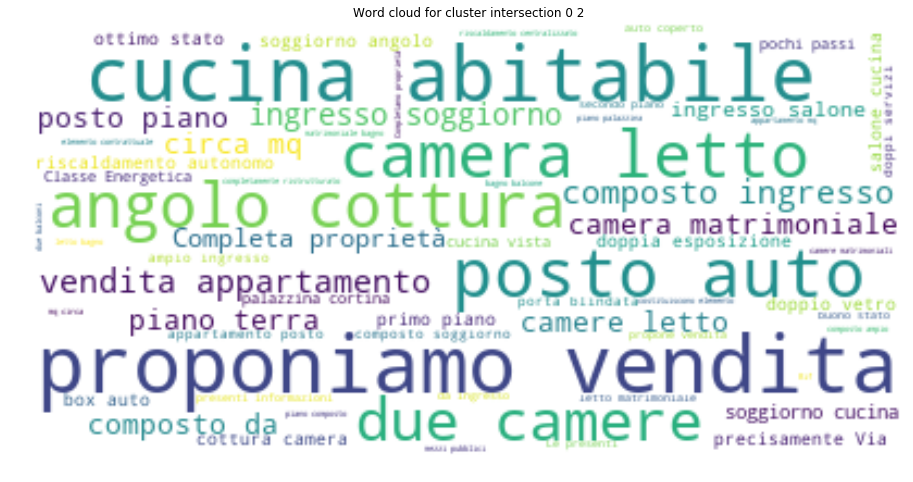

In [6]:
import comparison_functions

comparison_functions.word_clouder(features_cluster_list,0,descriptions_cluster_list,2,list_description)

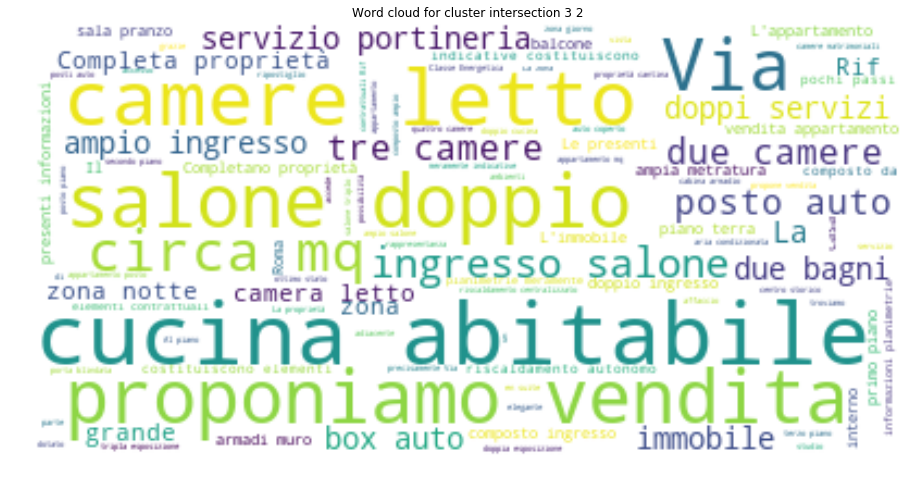

In [7]:
import comparison_functions

comparison_functions.word_clouder(features_cluster_list,3,descriptions_cluster_list,2,list_description)

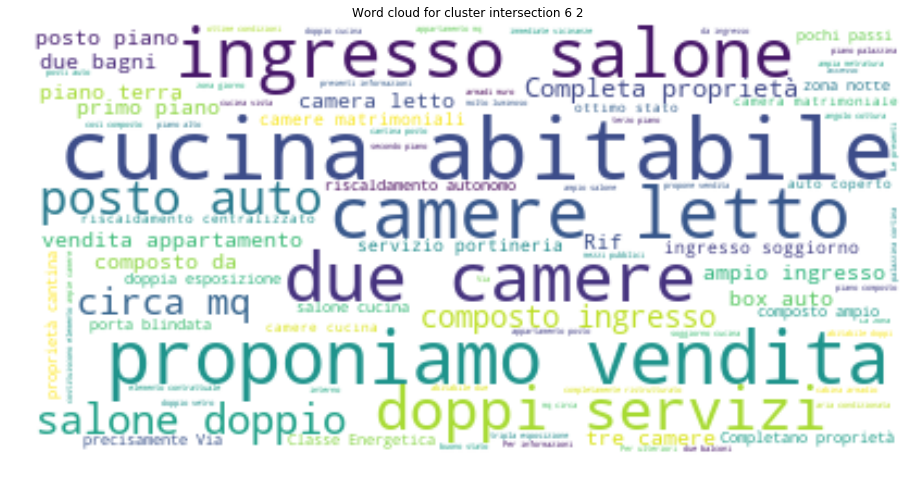

In [8]:
import comparison_functions

comparison_functions.word_clouder(features_cluster_list,6,descriptions_cluster_list,2,list_description)

# Find the duplicates!

Our aim in this section is to find duplicates in a list of string, seen as passwords.

As the passwords2.txt file is too huge to process we created passwords3.txt file and picked first one million records from password2.txt and created one duplicate string with changing the order and other duplicate with same order let us define our hash functions.

We define $HN$ a prime number. It will be the max length of our hash table. When we will build the hash function we modulate it with $HN$ so our hash function always return value below $HN$.

In [2]:
HN=32452843

We now look for duplicates not considering the ordering of the letters.

In [17]:
from hash_functions import calculationhashwithoutsequence

hashmap=[None]*HN
duplicates=0
falsepositives=0
#we defined Hashmap of None of length HN and declared out counters of duplicates and false positives
#Now for finding duplicated without sequence we would have following code
with open('passwords3.txt', 'r') as text:
    for line in text:
        line=line.strip() #read the lines and remove endline from the end of everyline
        index=calculationhashwithoutsequence(line) #calculating hash of every string
        line="".join(sorted(list(line))) #sorting the line in order of their ASCII character (for matching purpose)
        if(hashmap[index] is None): # if there is none at the index returned by hash function create a dictionary at that index 
            hashmap[index]=dict()
        if(line in hashmap[index]): #check is there is character present in dictionary keys available at index returned by hash function 
            hashmap[index][line]+=1 #if there is already a key of that character on hash function then duplication occurs and we make its count++
            duplicates+=1 
        else:
            hashmap[index][line]=1 #if there is no key avaiable at hash index then we create the specific key in the dictionary and set value as one mentioning the this string has occured one time
            if(len(hashmap[index])>1): #if there is already another value in dictionary in hash index then there is a false positive case
                falsepositives+=1

print("Number of duplicates are: ",duplicates," and false positives are: ",falsepositives)

Number of duplicates are:  2  and false positives are:  47


From the result we can see that we had two matches without sequence and fourty seven false positive.

Now we consider instead the length of the string.

In [18]:
from hash_functions import calculationhashwithsequence

hashmap=[None]*HN
duplicates=0
falsepositives=0
#we defined Hashmap of None of length HN and declared out counters of duplicates and false positives
#Now for finding duplicated without sequence we would have following code
with open('passwords3.txt', 'r') as text:
    for line in text:
        line=line.strip() #read the lines and remove endline from the end of everyline
        index=calculationhashwithsequence(line) #calculating hash of every string
        if(hashmap[index] is None): # if there is none at the index returned by hash function create a dictionary at that index 
            hashmap[index]=dict()
        if(line in hashmap[index]): #check is there is character present in dictionary keys available at index returned by hash function 
            hashmap[index][line]+=1 #if there is already a key of that character on hash function then duplication occurs and we make its count++
            duplicates+=1 
        else:
            hashmap[index][line]=1 #if there is no key avaiable at hash index then we create the specific key in the dictionary and set value as one mentioning the this string has occured one time
            if(len(hashmap[index])>1): #if there is already another value in dictionary in hash index then there is a false positive case
                falsepositives+=1

print("Number of duplicates are: ",duplicates," and false positives are: ",falsepositives)

Number of duplicates are:  1  and false positives are:  34


We can see from the result that we have correctly detected one match from the given string.